In [1]:
import os
import random
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
plt.rcParams['font.family'] = 'Malgun Gothic'


def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    #pythonhashseed 환경변수 설정
    np.random.seed(seed)

seed_everything(42)



light_df = pd.read_csv('./data/external_open/대구 보안등 정보.csv', encoding='cp949')[['설치개수', '소재지지번주소']]

location_pattern = r'(\S+) (\S+) (\S+) (\S+)'
#공백으로 구분된 네 개의 비공백 문자열을 찾음

light_df[['도시', '구', '동', '번지']] = light_df['소재지지번주소'].str.extract(location_pattern)
light_df = light_df.drop(columns=['소재지지번주소', '번지'])


# Sum -> Mean으로 변경
# 비교해보니 직접 동 별로 평균 계산 한 값과 동일했습니다
light_df = light_df.groupby(['도시', '구', '동']).mean().reset_index()
light_df.reset_index(inplace=True, drop=True)


child_area_df = pd.read_csv('./data/external_open/대구 어린이 보호 구역 정보.csv', encoding='cp949')[['소재지지번주소']]
#중복된 값이 있으면 값이 겹칠 수 있으니 미리 중복 제거 
child_area_df['School Zone'] = 1

location_pattern = r'(\S+) (\S+) (\S+) (\S+)'

child_area_df[['도시', '구', '동', '번지']] = child_area_df['소재지지번주소'].str.extract(location_pattern)
child_area_df = child_area_df.drop(columns=['소재지지번주소', '번지'])


# Sum -> Mean으로 변경
child_area_df = child_area_df.groupby(['도시', '구', '동']).mean().reset_index()
child_area_df.reset_index(inplace=True, drop=True)


parking_df = pd.read_csv('./data/external_open/대구 주차장 정보.csv', encoding='cp949')[['소재지지번주소', '급지구분']]
parking_df = pd.get_dummies(parking_df, columns=['급지구분'])
#parking_df값들을 one_hot encoding으로 진행

location_pattern = r'(\S+) (\S+) (\S+) (\S+)'

parking_df[['도시', '구', '동', '번지']] = parking_df['소재지지번주소'].str.extract(location_pattern)
parking_df = parking_df.drop(columns=['소재지지번주소', '번지'])

# Sum -> Mean으로 변경
parking_df = parking_df.groupby(['도시', '구', '동']).mean().reset_index()
parking_df.reset_index(inplace=True, drop=True)

In [2]:
train_org = pd.read_csv("./data/train.csv")
test_org = pd.read_csv("./data/test.csv")

countrywide_org = pd.read_csv('./data/external_open/countrywide_accident.csv')

display(train_org.head(3))
display(test_org.head(3))

,ID,사고일시,요일,기상상태,시군구,도로형태,노면상태,사고유형,사고유형 - 세부분류,법규위반,가해운전자 차종,가해운전자 성별,가해운전자 연령,가해운전자 상해정도,피해운전자 차종,피해운전자 성별,피해운전자 연령,피해운전자 상해정도,사망자수,중상자수,경상자수,부상자수,ECLO
0,ACCIDENT_00000,2019-01-01 00,화요일,맑음,대구광역시 중구 대신동,단일로 - 기타,건조,차대사람,길가장자리구역통행중,안전운전불이행,승용,여,51세,상해없음,보행자,여,70세,중상,0,1,0,0,5
1,ACCIDENT_00001,2019-01-01 00,화요일,흐림,대구광역시 달서구 감삼동,단일로 - 기타,건조,차대사람,보도통행중,기타,승용,남,39세,상해없음,보행자,남,61세,경상,0,0,1,0,3
2,ACCIDENT_00002,2019-01-01 01,화요일,맑음,대구광역시 수성구 두산동,단일로 - 기타,건조,차대사람,차도통행중,안전운전불이행,승용,남,70세,상해없음,보행자,남,38세,경상,0,0,1,0,3


,ID,사고일시,요일,기상상태,시군구,도로형태,노면상태,사고유형
0,ACCIDENT_39609,2022-01-01 01,토요일,맑음,대구광역시 수성구 상동,교차로 - 교차로안,건조,차대사람
1,ACCIDENT_39610,2022-01-01 01,토요일,맑음,대구광역시 수성구 지산동,단일로 - 기타,건조,차대사람
2,ACCIDENT_39611,2022-01-01 04,토요일,맑음,대구광역시 수성구 수성동2가,교차로 - 교차로안,건조,차대차


In [3]:
train_df = train_org.copy()
test_df = test_org.copy()
countrywide_df = countrywide_org.copy()


accident_counts = train_df['시군구'].value_counts().reset_index()
accident_counts.columns = ['시군구', '사고횟수']

train_df['사고발생횟수'] = train_df['시군구'].map(accident_counts.set_index('시군구')['사고횟수'])
test_df['사고발생횟수'] = test_df['시군구'].map(accident_counts.set_index('시군구')['사고횟수'])

accident_counts = countrywide_df['시군구'].value_counts().reset_index()
accident_counts.columns = ['시군구', '사고횟수']

countrywide_df['사고발생횟수'] = countrywide_df['시군구'].map(accident_counts.set_index('시군구')['사고횟수'])



time_pattern = r'(\d{4})-(\d{1,2})-(\d{1,2}) (\d{1,2})' 

train_df[['연', '월', '일', '시간']] = train_org['사고일시'].str.extract(time_pattern)
train_df[['연', '월', '일', '시간']] = train_df[['연', '월', '일', '시간']].apply(pd.to_numeric)
train_df = train_df.drop(columns=['사고일시'])

test_df[['연', '월', '일', '시간']] = test_org['사고일시'].str.extract(time_pattern)
test_df[['연', '월', '일', '시간']] = test_df[['연', '월', '일', '시간']].apply(pd.to_numeric)
test_df = test_df.drop(columns=['사고일시'])

countrywide_df[['연', '월', '일', '시간']] = countrywide_org['사고일시'].str.extract(time_pattern)
countrywide_df[['연', '월', '일', '시간']] = countrywide_df[['연', '월', '일', '시간']].apply(pd.to_numeric)
countrywide_df = countrywide_df.drop(columns=['사고일시'])



location_pattern = r'(\S+) (\S+) (\S+)'

train_df[['도시', '구', '동']] = train_org['시군구'].str.extract(location_pattern)
train_df = train_df.drop(columns=['시군구'])

test_df[['도시', '구', '동']] = test_org['시군구'].str.extract(location_pattern)
test_df = test_df.drop(columns=['시군구'])

countrywide_df[['도시', '구', '동']] = countrywide_org['시군구'].str.extract(location_pattern)
countrywide_df = countrywide_df.drop(columns=['시군구'])



road_pattern = r'(.+) - (.+)'

train_df[['도로형태1', '도로형태2']] = train_org['도로형태'].str.extract(road_pattern)
train_df = train_df.drop(columns=['도로형태'])

test_df[['도로형태1', '도로형태2']] = test_org['도로형태'].str.extract(road_pattern)
test_df = test_df.drop(columns=['도로형태'])

countrywide_df[['도로형태1', '도로형태2']] = countrywide_org['도로형태'].str.extract(road_pattern)
countrywide_df = countrywide_df.drop(columns=['도로형태'])


In [4]:
# train_df와 test_df에, light_df와 child_area_df, parking_df를 merge하세요.
train_df = pd.merge(train_df, light_df, how='left', on=['도시', '구', '동'])
train_df = pd.merge(train_df, child_area_df, how='left', on=['도시', '구', '동'])
train_df = pd.merge(train_df, parking_df, how='left', on=['도시', '구', '동'])

test_df = pd.merge(test_df, light_df, how='left', on=['도시', '구', '동'])
test_df = pd.merge(test_df, child_area_df, how='left', on=['도시', '구', '동'])
test_df = pd.merge(test_df, parking_df, how='left', on=['도시', '구', '동'])


countrywide_df = pd.merge(countrywide_df, light_df, how='left', on=['도시', '구', '동'])
countrywide_df = pd.merge(countrywide_df, child_area_df, how='left', on=['도시', '구', '동'])
countrywide_df = pd.merge(countrywide_df, parking_df, how='left', on=['도시', '구', '동'])

print(train_df.shape, test_df.shape, countrywide_df.shape)
display(train_df)

(39609, 35) (10963, 20) (602775, 35)


,ID,요일,기상상태,노면상태,사고유형,사고유형 - 세부분류,법규위반,가해운전자 차종,가해운전자 성별,가해운전자 연령,가해운전자 상해정도,피해운전자 차종,피해운전자 성별,피해운전자 연령,피해운전자 상해정도,사망자수,중상자수,경상자수,부상자수,ECLO,사고발생횟수,연,월,일,시간,도시,구,동,도로형태1,도로형태2,설치개수,School Zone,급지구분_1,급지구분_2,급지구분_3
0,ACCIDENT_00000,화요일,맑음,건조,차대사람,길가장자리구역통행중,안전운전불이행,승용,여,51세,상해없음,보행자,여,70세,중상,0,1,0,0,5,131,2019,1,1,0,대구광역시,중구,대신동,단일로,기타,1.000000,1.0,1.000000,0.000000,0.000000
1,ACCIDENT_00001,화요일,흐림,건조,차대사람,보도통행중,기타,승용,남,39세,상해없음,보행자,남,61세,경상,0,0,1,0,3,678,2019,1,1,0,대구광역시,달서구,감삼동,단일로,기타,1.000000,NaN,0.000000,0.250000,0.750000
2,ACCIDENT_00002,화요일,맑음,건조,차대사람,차도통행중,안전운전불이행,승용,남,70세,상해없음,보행자,남,38세,경상,0,0,1,0,3,604,2019,1,1,1,대구광역시,수성구,두산동,단일로,기타,1.000000,1.0,NaN,NaN,NaN
3,ACCIDENT_00003,화요일,맑음,건조,차대차,추돌,안전운전불이행,승용,남,49세,상해없음,승용,남,36세,중상,0,1,0,0,5,426,2019,1,1,2,대구광역시,북구,복현동,단일로,기타,1.000000,1.0,0.000000,0.642857,0.357143
4,ACCIDENT_00004,화요일,맑음,건조,차대차,추돌,안전운전불이행,승용,남,30세,상해없음,승용,남,52세,경상,0,0,1,0,3,825,2019,1,1,4,대구광역시,동구,신암동,단일로,기타,1.031078,NaN,0.000000,1.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39604,ACCIDENT_39604,금요일,맑음,건조,차대차,측면충돌,신호위반,승용,여,52세,상해없음,이륜,남,28세,경상,0,0,1,0,3,104,2021,12,31,19,대구광역시,수성구,수성동3가,교차로,교차로안,NaN,1.0,NaN,NaN,NaN
39605,ACCIDENT_39605,금요일,맑음,건조,차대차,측면충돌,안전거리미확보,승용,여,60세,상해없음,승용,남,52세,경상,0,0,1,0,3,1143,2021,12,31,19,대구광역시,달서구,상인동,단일로,기타,1.000000,NaN,0.000000,0.000000,1.000000
39606,ACCIDENT_39606,금요일,맑음,건조,차대차,측면충돌,교차로운행방법위반,승용,남,60세,중상,승용,남,73세,중상,0,2,0,0,10,618,2021,12,31,21,대구광역시,달서구,월성동,교차로,교차로안,1.000000,NaN,0.000000,1.000000,0.000000
39607,ACCIDENT_39607,금요일,맑음,건조,차대차,추돌,안전운전불이행,승용,남,40세,상해없음,승용,여,57세,경상,0,0,1,0,3,125,2021,12,31,22,대구광역시,달서구,장동,기타,기타,1.000000,NaN,0.000000,0.000000,1.000000


In [5]:
# train_df.to_csv("./data/train_data_total1206.csv", encoding="cp949")
# test_df.to_csv("./data/test_data_total1206.csv", encoding="cp949")
# countrywide_df.to_csv("./data/countrywide_data_total1206.csv", encoding="cp949")

total_df = pd.concat([train_df,countrywide_df])
total_df.shape

test_x = test_df.drop(columns=['ID']).copy()
train_x = total_df[test_x.columns].copy()
train_y = total_df['ECLO'].copy()

print(train_x.shape, train_y.shape, test_x.shape)
print(train_x.columns)
# countrywide_df.columns

(642384, 19) (642384,) (10963, 19)
Index(['요일', '기상상태', '노면상태', '사고유형', '사고발생횟수', '연', '월', '일', '시간', '도시', '구',
       '동', '도로형태1', '도로형태2', '설치개수', 'School Zone', '급지구분_1', '급지구분_2',
       '급지구분_3'],
      dtype='object')


In [6]:
# 급지구분 채우기
# 대구에서 nan은 같은 구의 평균 값,  대구 밖에서 nan 값은 대구의 평균 값으로 채우기

# train
for gu in sorted(parking_df['구'].unique()):
    gu_mean_ground = parking_df[parking_df['구'] == gu][['급지구분_1', '급지구분_2', '급지구분_3']].mean()

    for j in sorted(train_x[train_x['구'] == gu]['구'].unique()):
        if gu == j:
            nan_mask = train_x['구'] == gu
            nan_mask_1 = pd.isnull(train_x['급지구분_1'])
            nan_mask_2 = pd.isnull(train_x['급지구분_2'])
            nan_mask_3 = pd.isnull(train_x['급지구분_3'])

            
            train_x.loc[nan_mask & nan_mask_1, '급지구분_1'] = gu_mean_ground['급지구분_1']
            train_x.loc[nan_mask & nan_mask_2, '급지구분_2'] = gu_mean_ground['급지구분_2']
            train_x.loc[nan_mask & nan_mask_3, '급지구분_3'] = gu_mean_ground['급지구분_3']



daegu_mean_ground = parking_df[parking_df['도시']=='대구광역시'][['급지구분_1','급지구분_2','급지구분_3']].mean()

train_x['급지구분_1'] = train_x['급지구분_1'].fillna(daegu_mean_ground['급지구분_1'])
train_x['급지구분_2'] = train_x['급지구분_2'].fillna(daegu_mean_ground['급지구분_2'])
train_x['급지구분_3'] = train_x['급지구분_3'].fillna(daegu_mean_ground['급지구분_3'])

# test
for gu in sorted(parking_df['구'].unique()):
    gu_mean_ground = parking_df[parking_df['구'] == gu][['급지구분_1', '급지구분_2', '급지구분_3']].mean()

    for j in sorted(test_x[test_x['구'] == gu]['구'].unique()):
        if gu == j:
            nan_mask = test_x['구'] == gu
            nan_mask_1 = pd.isnull(test_x['급지구분_1'])
            nan_mask_2 = pd.isnull(test_x['급지구분_2'])
            nan_mask_3 = pd.isnull(test_x['급지구분_3'])

            
            test_x.loc[nan_mask & nan_mask_1, '급지구분_1'] = gu_mean_ground['급지구분_1']
            test_x.loc[nan_mask & nan_mask_2, '급지구분_2'] = gu_mean_ground['급지구분_2']
            test_x.loc[nan_mask & nan_mask_3, '급지구분_3'] = gu_mean_ground['급지구분_3']



daegu_mean_ground = parking_df[parking_df['도시']=='대구광역시'][['급지구분_1','급지구분_2','급지구분_3']].mean()

test_x['급지구분_1'] = test_x['급지구분_1'].fillna(daegu_mean_ground['급지구분_1'])
test_x['급지구분_2'] = test_x['급지구분_2'].fillna(daegu_mean_ground['급지구분_2'])
test_x['급지구분_3'] = test_x['급지구분_3'].fillna(daegu_mean_ground['급지구분_3'])

# train_x[['구', '동','급지구분_1', '급지구분_2', '급지구분_3']]

In [7]:
# 보안등 정보 채우기
# 대구에서 nan은 같은 구의 평균 값,  대구 밖에서 nan 값은 대구의 평균 값으로 채우기

# train
for gu in sorted(light_df['구'].unique()):
    gu_mean_light= light_df[light_df['구'] == gu][['설치개수']].mean()

    for j in sorted(train_x[train_x['구'] == gu]['구'].unique()):
        if gu == j:
            nan_mask = train_x['구'] == gu
            nan_mask_1 = pd.isnull(train_x['설치개수'])
            
            train_x.loc[nan_mask & nan_mask_1, '설치개수'] = gu_mean_light['설치개수']


# train_x['설치개수'] = train_x['설치개수'].fillna(1)
daegu_mean_light = light_df[light_df['도시']=='대구광역시'][['설치개수']].mean()

train_x['설치개수'] = train_x['설치개수'].fillna(daegu_mean_light['설치개수'])


# test
for gu in sorted(light_df['구'].unique()):
    gu_mean_light= light_df[light_df['구'] == gu][['설치개수']].mean()

    for j in sorted(test_x[test_x['구'] == gu]['구'].unique()):
        if gu == j:
            nan_mask = test_x['구'] == gu
            nan_mask_1 = pd.isnull(test_x['설치개수'])
            
            test_x.loc[nan_mask & nan_mask_1, '설치개수'] = gu_mean_light['설치개수']



daegu_mean_light = light_df[light_df['도시']=='대구광역시'][['설치개수']].mean()

test_x['설치개수'] = test_x['설치개수'].fillna(daegu_mean_light['설치개수'])



# 스쿨존이면 1, 없으면 0으로 채움. 
# 주어진 정보가 없으니 스쿨존이 아니라고 (0) 판단.
train_x['School Zone'] = train_x['School Zone'].fillna(0)
test_x['School Zone'] = test_x['School Zone'].fillna(0)

In [8]:
from sklearn.preprocessing import LabelEncoder
from category_encoders.target_encoder import TargetEncoder

categorical_features = list(train_x.dtypes[train_x.dtypes == "object"].index) #object값 list에 넣음
# 추출된 문자열 변수 확인
display(categorical_features) #object값 출력

for i in categorical_features: #인코딩 적용한 값 반환
    le = TargetEncoder(cols=[i])
    train_x[i] = le.fit_transform(train_x[i], train_y)
    test_x[i] = le.transform(test_x[i])
#target encdoer 주의사항: train은 fit_transform인 반면, test는 transform만 진행!

    
display(train_x.head())
display(test_x.head())

['요일', '기상상태', '노면상태', '사고유형', '도시', '구', '동', '도로형태1', '도로형태2']

,요일,기상상태,노면상태,사고유형,사고발생횟수,연,월,일,시간,도시,구,동,도로형태1,도로형태2,설치개수,School Zone,급지구분_1,급지구분_2,급지구분_3
0,4.806525,4.916983,4.918983,4.033662,131,2019,1,1,0,4.726704,4.751841,4.118483,4.929523,4.838197,1.000000,1.0,1.000000,0.000000,0.000000
1,4.806525,5.064802,4.918983,4.033662,678,2019,1,1,0,4.726704,4.618441,4.738938,4.929523,4.838197,1.000000,0.0,0.000000,0.250000,0.750000
2,4.806525,4.916983,4.918983,4.033662,604,2019,1,1,1,4.726704,4.727300,4.847541,4.929523,4.838197,1.000000,1.0,0.104167,0.381944,0.513889
3,4.806525,4.916983,4.918983,5.161454,426,2019,1,1,2,4.726704,4.869590,4.208920,4.929523,4.838197,1.000000,1.0,0.000000,0.642857,0.357143
4,4.806525,4.916983,4.918983,5.161454,825,2019,1,1,4,4.726704,4.844429,4.549091,4.929523,4.838197,1.031078,0.0,0.000000,1.000000,0.000000


,요일,기상상태,노면상태,사고유형,사고발생횟수,연,월,일,시간,도시,구,동,도로형태1,도로형태2,설치개수,School Zone,급지구분_1,급지구분_2,급지구분_3
0,5.216801,4.916983,4.918983,4.033662,338,2022,1,1,1,4.726704,4.727300,5.043729,4.993857,5.124537,1.0,1.0,0.104167,0.381944,0.513889
1,5.216801,4.916983,4.918983,4.033662,492,2022,1,1,1,4.726704,4.727300,4.857019,4.929523,4.838197,1.0,1.0,0.000000,0.000000,1.000000
2,5.216801,4.916983,4.918983,5.161454,147,2022,1,1,4,4.726704,4.727300,4.945578,4.993857,5.124537,1.0,1.0,0.104167,0.381944,0.513889
3,5.216801,4.916983,4.918983,5.161454,372,2022,1,1,4,4.726704,4.727300,4.438172,4.929523,4.838197,1.0,1.0,0.000000,0.666667,0.333333
4,5.216801,4.916983,4.918983,5.161454,678,2022,1,1,6,4.726704,4.618441,4.738938,4.993857,5.124537,1.0,0.0,0.000000,0.250000,0.750000


In [9]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
def calculate_vif(dataframe):
    vif_data = pd.DataFrame()
    vif_data["feature"] = dataframe.columns
    vif_data["VIF"] = [variance_inflation_factor(dataframe.values, i) for i in range(dataframe.shape[1])]
    vif_data['VIF'] = vif_data['VIF'].apply(lambda x: f"{x:.2f}")
    return vif_data

vif_df = calculate_vif(train_x) 
print(vif_df)

        feature         VIF
0            요일        1.00
1          기상상태        1.53
2          노면상태        1.53
3          사고유형        1.07
4        사고발생횟수        1.22
5             연        1.01
6             월        1.00
7             일        1.00
8            시간        1.00
9            도시        2.54
10            구        3.33
11            동        1.95
12        도로형태1        1.08
13        도로형태2        1.13
14         설치개수        1.07
15  School Zone        1.12
16       급지구분_1  1206354.81
17       급지구분_2   292499.03
18       급지구분_3  1087445.11


In [10]:
# columns_to_drop = ['급지구분_1','급지구분_2','급지구분_3'] # vif 값 높은 school zone 제거

# train_x와 test_x에서 해당 열들을 제거
# train_x = train_x.drop(columns=columns_to_drop, axis=1)
# test_x = test_x.drop(columns=columns_to_drop, axis=1)



# 급지구분이 vif가 높지만 드랍 X

In [11]:
train_x.to_csv("./data/train_x_modify_fillna_1208.csv", encoding="cp949")
train_y.to_csv("./data/train_y_modify_fillna_1208.csv", encoding="cp949")

test_x.to_csv("./data/test_x_modify_fillna_1208.csv", encoding="cp949")

# train_y = total_df['ECLO'].copy()

In [12]:
import tensorflow as tf
from tensorflow.keras.regularizers import l1 as l1_regularizer, l2 as l2_regularizer

def rmsle(y_true, y_pred):
    # y_true = tf.cast(y_true, tf.float32)
    # y_pred = tf.cast(y_pred, tf.float32)
    # squared_error = tf.square(tf.math.log1p(y_pred) - tf.math.log1p(y_true))
    # return tf.sqrt(tf.reduce_mean(squared_error))
    
    y_true = tf.maximum(tf.cast(y_true, tf.float32), 0)
    y_pred = tf.maximum(tf.cast(y_pred, tf.float32), 0)
    squared_error = tf.square(tf.math.log1p(y_pred) - tf.math.log1p(y_true))
    
    return tf.sqrt(tf.reduce_mean(squared_error))

def loss_fn(y_true, y_pred):
    return rmsle(y_true, y_pred)

def metric_fn(y_true, y_pred):
    return rmsle(y_true, y_pred)

cos_ann_lr = tf.keras.experimental.CosineDecayRestarts(initial_learning_rate=0.001, first_decay_steps=35, t_mul=1, m_mul=0.9, alpha=0.0000001)

callbacks_list = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=30, verbose=2, mode='min', restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.7, patience=4, min_lr=0.00001),
    tf.keras.callbacks.TerminateOnNaN(),
    tf.keras.callbacks.LearningRateScheduler(cos_ann_lr)
] 

def create_model(l1_reg, l2_reg, learning_rate):
    input_layer = tf.keras.Input(shape=(len(train_x.columns),))
    print(input_layer)
    x = tf.keras.layers.BatchNormalization(epsilon=0.00001)(input_layer)
    x = tf.keras.layers.Dense(24, kernel_regularizer=l2_regularizer(l2_reg))(x)
    x = tf.keras.layers.BatchNormalization(epsilon=0.00001)(x)
    x = tf.keras.layers.Activation('relu')(x)
    
    x = tf.keras.layers.Dense(48, kernel_regularizer=l2_regularizer(l2_reg))(x)
    x = tf.keras.layers.BatchNormalization(epsilon=0.00001)(x)
    x = tf.keras.layers.Activation('relu')(x)
    
    output_layer = tf.keras.layers.Dense(1)(x)
    
    model = tf.keras.Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),
                  loss=loss_fn,
                  metrics=[metric_fn])
    return model

best_params = {'batch_size': 128, 'l1_reg': 0.0001, 'l2_reg': 0.0001, 'learning_rate': 0.001}
optimized_model = create_model(best_params['l1_reg'], best_params['l2_reg'], best_params['learning_rate'])

KerasTensor(type_spec=TensorSpec(shape=(None, 19), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")


In [13]:
# 에폭 10번 !! 원랜 100


from sklearn.model_selection import KFold

skf = KFold(n_splits=5, shuffle=True, random_state=42)

fold_histories = []
test_preds = np.zeros(len(test_x))

for i, (train_index, valid_index) in enumerate(skf.split(train_x, train_y)):
    print(f'-------------------{ i }-------------------------')
    # print(train_index)
    x_train_fold, x_valid_fold = train_x.iloc[train_index], train_x.iloc[valid_index]
    y_train_fold, y_valid_fold = train_y.iloc[train_index], train_y.iloc[valid_index]
    # print(x_train_fold.shape, x_valid_fold.shape, y_train_fold.shape,y_valid_fold.shape)
    
    optimized_model = create_model(best_params['l1_reg'], best_params['l2_reg'], best_params['learning_rate'])
    history = optimized_model.fit(
                            x_train_fold.astype('float32'), y_train_fold.astype('float32'),
                            epochs=111, batch_size=best_params['batch_size'], verbose=1,
                            validation_data=(x_valid_fold.astype('float32'), y_valid_fold.astype('float32')),
                            callbacks=callbacks_list)
    
    fold_histories.append(history)
    
    test_preds +=  optimized_model.predict(test_x.astype('float32')).reshape(-1) / skf.n_splits

-------------------0-------------------------
KerasTensor(type_spec=TensorSpec(shape=(None, 19), dtype=tf.float32, name='input_2'), name='input_2', description="created by layer 'input_2'")
Epoch 1/111
4015/4015 [==============================] - 12s 3ms/step - loss: 0.4519 - metric_fn: 0.4476 - val_loss: 0.4403 - val_metric_fn: 0.4369 - lr: 0.0010
Epoch 2/111
4015/4015 [==============================] - 10s 2ms/step - loss: 0.4413 - metric_fn: 0.4385 - val_loss: 0.4389 - val_metric_fn: 0.4366 - lr: 9.9799e-04
Epoch 3/111
4015/4015 [==============================] - 10s 3ms/step - loss: 0.4398 - metric_fn: 0.4380 - val_loss: 0.4375 - val_metric_fn: 0.4360 - lr: 9.9196e-04
Epoch 4/111
4015/4015 [==============================] - 10s 3ms/step - loss: 0.4390 - metric_fn: 0.4376 - val_loss: 0.4380 - val_metric_fn: 0.4368 - lr: 9.8198e-04
Epoch 5/111
4015/4015 [==============================] - 10s 3ms/step - loss: 0.4384 - metric_fn: 0.4374 - val_loss: 0.4368 - val_metric_fn: 0.4358 - lr: 

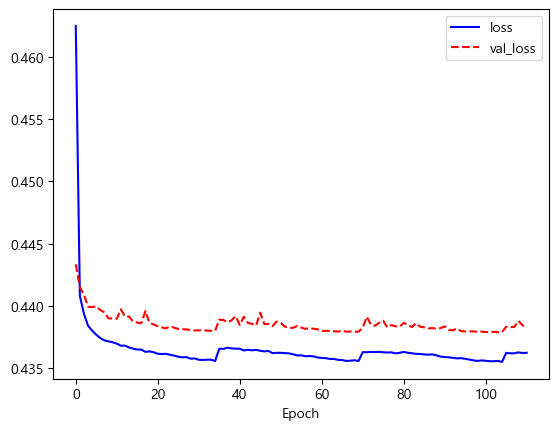

In [14]:
# train loss, val loss 시각화
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], 'b-', label='loss')
plt.plot(history.history['val_loss'], 'r--', label='val_loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

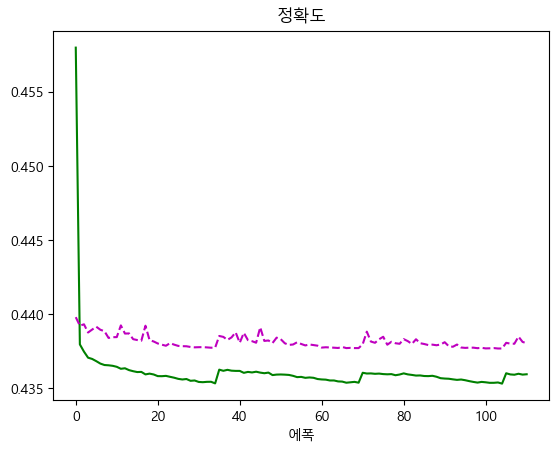

In [15]:

plt.plot(history.history['metric_fn'], 'g-', label='rmsle ')
plt.plot(history.history['val_metric_fn'], 'm--', label='rmsle_val')
plt.xlabel('에폭')
plt.title('정확도')
plt.show()


In [16]:
sample_submission = pd.read_csv('data/sample_submission.csv')

sample_submission["ECLO"] = test_preds

sample_submission.to_csv("result/1207_modify_fillna_addFeature.csv", index=False)
sample_submission["ECLO"]

0        4.042955
1        3.690329
2        4.901220
3        4.314729
4        4.491140
           ...   
10958    5.468163
10959    4.385062
10960    4.770700
10961    4.527964
10962    4.421367
Name: ECLO, Length: 10963, dtype: float64